# 기본 설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#시각화 글꼴 깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,695 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121753 files and dire

In [ ]:
import matplotlib.pyplot as plt #실행 전 런타임 다시 시작

plt.rc('font', family='NanumBarunGothic')
# 음수 부호까지 제대로 표시되도록 설정 추가
plt.rcParams['axes.unicode_minus'] = False

In [3]:
#필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import platform
import seaborn as sns

#plotly 시각화 라이브러리
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots #서브플롯 제작

pd.set_option('display.max_columns', None)
#warning 알림 무시
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
os.getcwd() # 현재 디렉토리 파악
os.chdir("/content/drive/Othercomputers/내 노트북/DNA/물류 유통량 예측 경진대회/")

In [4]:
train = pd.read_csv("final_train.csv")
test = pd.read_csv("final_test.csv")
submission_df =pd.read_csv("sample_submission.csv")

In [5]:
submission_df.head(3)

,index,운송장_건수
0,0,0
1,1,0
2,2,0


In [ ]:
#필요없는 변수 삭제
#문자형으로 되어있던 변수들 형변환

drop_col = ['index', '물품_카테고리', '송하인_시군구별','송하인_시도별','수하인_시군구별',
            '수하인_시도별','송하인_격자공간고유번호', '수하인_격자공간고유번호', '송하인_총유통시설수(시도)', '수하인_총유통시설수(시도)' ]

for d in [train, test]:
  d.drop(drop_col, axis=1, inplace=True)
  d['수하인 1인당 지역총소득'] = d['수하인 1인당 지역총소득'].str.replace(',', '')
  d['수하인 1인당 지역총소득'] = d['수하인 1인당 지역총소득'].astype('int64')
  d['송하인 1인당 지역총소득'] = d['송하인 1인당 지역총소득'].str.replace(',', '')
  d['송하인 1인당 지역총소득'] = d['송하인 1인당 지역총소득'].astype('int64')
  d['수하인_인구밀도'] = d['수하인_인구밀도'].str.replace(',','')
  d['수하인_인구밀도'] = d['수하인_인구밀도'].astype('int64')

In [ ]:
train.columns

Index(['운송장_건수', '송하인_시도', '송하인_시군구', '송하인_기타1', '송하인_기타2', '송하인_기타3',
       '송하인_기타4', '수하인_시도', '수하인_시군구', '수하인_기타1', '수하인_기타2', '수하인_기타3',
       '수하인_기타4', '송하인_1인가구', '송하인_다가구', '수하인_1인가구', '수하인_다가구',
       '송하인_1인가구(시군구)', '송하인_다가구(시군구)', '수하인_1인가구(시군구)', '수하인_다가구(시군구)',
       '송하인_총유통시설수(시군구)', '수하인_총유통시설수(시군구)', '물품대분류_코드', '물품중분류_코드', '물품종합코드',
       '수하인 도매업수', '송하인 도매업수', '수하인 1인당 지역총소득', '송하인 1인당 지역총소득', '수하인_농산물공판장수',
       '송하인_농산물공판장수', '수하인_인구밀도'],
      dtype='object')

In [ ]:
#feature scaling
#총유통시설수(시군구)의 경우에는 skew가 커 log변환 진행
#분포를 봤을 때, 시도별, 시군구별로 각 값을 대입하여 여러 쌍의 언덕이 나타남

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler

standard = StandardScaler()
minmax = MinMaxScaler()
robust = RobustScaler()

for d in [train, test]:
  d['송하인_총유통시설수(시군구)']  = np.log1p(d['송하인_총유통시설수(시군구)'])
  d['수하인_총유통시설수(시군구)']  = np.log1p(d['수하인_총유통시설수(시군구)'])


selected_columns = ['송하인_1인가구', '송하인_다가구', '수하인_1인가구', '수하인_다가구',
       '송하인_1인가구(시군구)', '송하인_다가구(시군구)', '수하인_1인가구(시군구)', '수하인_다가구(시군구)',
       '송하인_총유통시설수(시군구)', '수하인_총유통시설수(시군구)',
       '수하인 도매업수', '송하인 도매업수', '수하인 1인당 지역총소득', '송하인 1인당 지역총소득', '수하인_농산물공판장수',
       '송하인_농산물공판장수', '수하인_인구밀도']

In [ ]:

# MinMaxScaler를 사용하여 train 데이터와 test 데이터 스케일링
train[selected_columns] = minmax.fit_transform(train[selected_columns])
test[selected_columns] = minmax.transform(test[selected_columns])

In [ ]:
train[['수하인_농산물공판장수','송하인_농산물공판장수']] = minmax.fit_transform(train[['수하인_농산물공판장수','송하인_농산물공판장수']])
test[['수하인_농산물공판장수','송하인_농산물공판장수']] = minmax.transform(test[['수하인_농산물공판장수','송하인_농산물공판장수']])

# StandardScaler 사용하여 train 데이터와 test 데이터 스케일링
train[selected_columns] = standard.fit_transform(train[selected_columns])
test[selected_columns] = standard.transform(test[selected_columns])

In [ ]:
train[['수하인_농산물공판장수','송하인_농산물공판장수']] = minmax.fit_transform(train[['수하인_농산물공판장수','송하인_농산물공판장수']])
test[['수하인_농산물공판장수','송하인_농산물공판장수']] = minmax.transform(test[['수하인_농산물공판장수','송하인_농산물공판장수']])

train[selected_columns] = robust.fit_transform(train[selected_columns])
test[selected_columns] = robust.transform(test[selected_columns])

#이상치 최소화를 위해 robust로 다시 시행

In [ ]:
test = test[['송하인_시도','송하인_시군구','송하인_기타1','송하인_기타2','송하인_기타3','송하인_기타4',
              '수하인_시도','수하인_시군구','수하인_기타1','수하인_기타2','수하인_기타3','수하인_기타4',
               '송하인_1인가구(시군구)','송하인_다가구(시군구)','수하인_1인가구(시군구)','수하인_다가구(시군구)',
               '송하인_총유통시설수(시군구)','수하인_총유통시설수(시군구)','물품대분류_코드', '물품중분류_코드', '물품종합코드',
               '수하인 도매업수', '송하인 도매업수', '수하인_농산물공판장수', '송하인_농산물공판장수', '수하인_인구밀도']]


# 모델링 전처리

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.1 MB/s eta 0:00:00


In [ ]:
train.columns

Index(['운송장_건수', '송하인_시도', '송하인_시군구', '송하인_기타1', '송하인_기타2', '송하인_기타3',
       '송하인_기타4', '수하인_시도', '수하인_시군구', '수하인_기타1', '수하인_기타2', '수하인_기타3',
       '수하인_기타4', '송하인_1인가구', '송하인_다가구', '수하인_1인가구', '수하인_다가구',
       '송하인_1인가구(시군구)', '송하인_다가구(시군구)', '수하인_1인가구(시군구)', '수하인_다가구(시군구)',
       '송하인_총유통시설수(시군구)', '수하인_총유통시설수(시군구)', '물품대분류_코드', '물품중분류_코드', '물품종합코드',
       '수하인 도매업수', '송하인 도매업수', '수하인 1인당 지역총소득', '송하인 1인당 지역총소득', '수하인_농산물공판장수',
       '송하인_농산물공판장수', '수하인_인구밀도'],
      dtype='object')

In [ ]:
from re import VERBOSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
seed=42
target = train['운송장_건수']
X = train[['송하인_시도','송하인_시군구','송하인_기타1','송하인_기타2','송하인_기타3','송하인_기타4',
              '수하인_시도','수하인_시군구','수하인_기타1','수하인_기타2','수하인_기타3','수하인_기타4',
               '송하인_1인가구(시군구)','송하인_다가구(시군구)','수하인_1인가구(시군구)','수하인_다가구(시군구)',
               '송하인_총유통시설수(시군구)','수하인_총유통시설수(시군구)','물품대분류_코드', '물품중분류_코드', '물품종합코드',
               '수하인 도매업수', '송하인 도매업수', '수하인_농산물공판장수', '송하인_농산물공판장수', '수하인_인구밀도','cluster']]

# x,y 로 분리한 train 데이터를 train, val 데이터로 분할 0.3
X_train, X_valid, y_train, y_valid = train_test_split(X,target,test_size=0.2, random_state=seed)

In [ ]:
X_test = test[['송하인_시도','송하인_시군구','송하인_기타1','송하인_기타2','송하인_기타3','송하인_기타4',
              '수하인_시도','수하인_시군구','수하인_기타1','수하인_기타2','수하인_기타3','수하인_기타4',
               '송하인_1인가구(시군구)','송하인_다가구(시군구)','수하인_1인가구(시군구)','수하인_다가구(시군구)',
               '송하인_총유통시설수(시군구)','수하인_총유통시설수(시군구)','물품대분류_코드', '물품중분류_코드', '물품종합코드',
               '수하인 도매업수', '송하인 도매업수', '수하인_농산물공판장수', '송하인_농산물공판장수', '수하인_인구밀도', 'cluster']]

In [ ]:
print('train data 개수: ', X_train.shape)
print('test data 개수: ', X_valid.shape)

train data 개수:  (25347, 22)
test data 개수:  (6337, 22)


### 군집화 변수 생성해보기

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
#군집 갯수 찾아주기
#kmeans 우선으로 시행
inertia_arr = []
k_range = range(2,30)

for k in k_range:
  Kmeans = KMeans(n_clusters=k, random_state=42)
  Kmeans.fit(X_train)
  interia = Kmeans.inertia_
  print('k: {0}, inertia: {1:.4f}'.format(k, interia))

  inertia_arr.append(interia)

inertia_arr = np.array(inertia_arr)


k: 2, inertia: 2445769558704.1074
k: 3, inertia: 1145406277898.0991
k: 4, inertia: 587693210336.6130
k: 5, inertia: 238901703756.2862
k: 6, inertia: 113944528241.0770
k: 7, inertia: 42442757773.9656
k: 8, inertia: 31084029690.1109
k: 9, inertia: 23121325296.9380
k: 10, inertia: 17303241290.0331
k: 11, inertia: 13615136606.1626
k: 12, inertia: 11563733424.4229
k: 13, inertia: 9381072820.8301
k: 14, inertia: 7862200182.9575
k: 15, inertia: 6323371487.8103
k: 16, inertia: 5364150721.5365
k: 17, inertia: 4841278231.7372
k: 18, inertia: 4588171679.0984
k: 19, inertia: 4071469982.6484
k: 20, inertia: 3757965820.2717
k: 21, inertia: 3497966285.0718
k: 22, inertia: 3153979942.2772
k: 23, inertia: 2872024967.4630
k: 24, inertia: 2599184918.7647
k: 25, inertia: 2414848839.8863
k: 26, inertia: 2238465869.8650
k: 27, inertia: 2126194851.6693
k: 28, inertia: 2022204704.2765
k: 29, inertia: 1961836577.5875


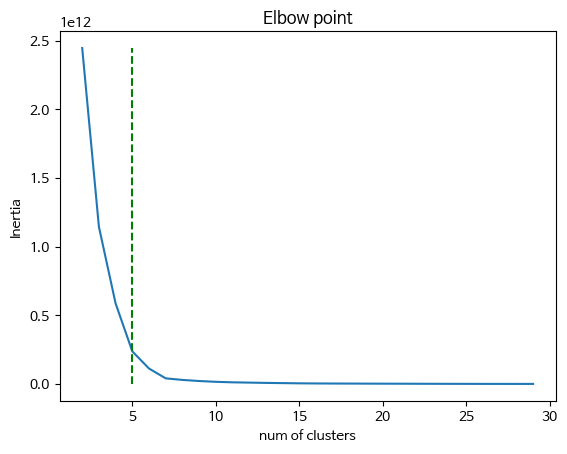

In [ ]:
plt.plot(k_range, inertia_arr)
plt.vlines(5, ymin=inertia_arr.min()*0.999, ymax=inertia_arr.max()*1.0003, linestyles="--", colors="g")

plt.title('Elbow point')
plt.xlabel("num of clusters")
plt.ylabel('Inertia')
plt.show()

In [ ]:
from sklearn.decomposition import PCA
pca= PCA(n_components =2)

pca_train = train.drop(['운송장_건수'], axis=1)
imple_data = pca.fit_transform(pca_train)
imple_data.shape

(31684, 2)

In [ ]:
pca.explained_variance_ratio_

array([0.74396251, 0.23337812])

In [ ]:
Kmeans = KMeans(n_clusters=k, random_state=42)
Kmeans.fit(imple_data)
cluster = Kmeans.predict(imple_data)
center = Kmeans.cluster_centers_ #중심점 확인

In [ ]:
imple_data = pd.DataFrame(imple_data)

In [ ]:
imple_data['cluster'] = cluster
imple_data.rename(columns={0:"PC1", 1:"PC2"}, inplace=True)

Text(0.5, 1.0, 'n=5 cluster')

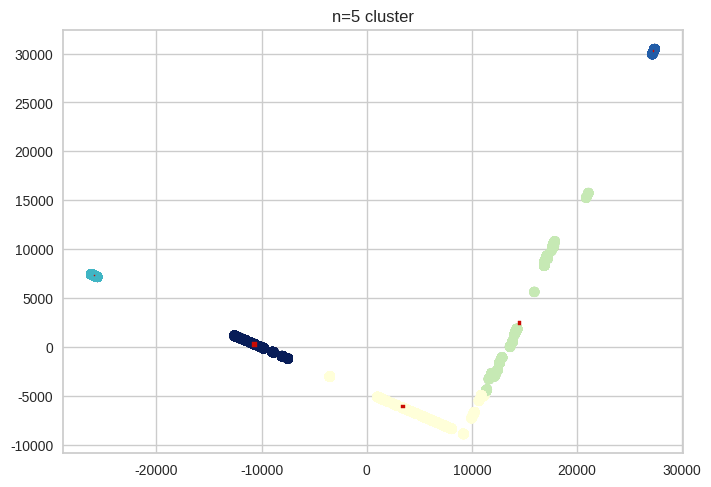

In [ ]:
plt.scatter(imple_data['PC1'], imple_data['PC2'], c=imple_data['cluster'], cmap="YlGnBu")
plt.scatter(center[:, 0], center[:, 1], center[:, 2], c="r", marker="s")
plt.title("n=5 cluster")

In [ ]:
#실루엣 스코어 확인
from sklearn.metrics import silhouette_score

k_range = range(2,30)

best_n = -1
best_silhouette_score = -1

for k in k_range:
  Kmeans = KMeans(n_clusters=k, random_state=42)
  Kmeans.fit(X_train)
  clusters = Kmeans.predict(X_train)

  score = silhouette_score(X_train, clusters)
  print('k: {0}, inertia: {1:.4f}'.format(k, score))

  if score > best_silhouette_score:
    best_n = k
    best_silhouette_score = score
print('best n: {0}, best score: {1:.4f}'.format(best_n, best_silhouette_score))

k: 2, inertia: 0.6356
k: 3, inertia: 0.6847
k: 4, inertia: 0.7281
k: 5, inertia: 0.7763
k: 6, inertia: 0.8042
k: 7, inertia: 0.8086
k: 8, inertia: 0.8011
k: 9, inertia: 0.7600
k: 10, inertia: 0.7578
k: 11, inertia: 0.7702
k: 12, inertia: 0.7618
k: 13, inertia: 0.7633
k: 14, inertia: 0.7607
k: 15, inertia: 0.7563
k: 16, inertia: 0.7290
k: 17, inertia: 0.7326
k: 18, inertia: 0.7276
k: 19, inertia: 0.7256
k: 20, inertia: 0.7355
k: 21, inertia: 0.7342
k: 22, inertia: 0.7289
k: 23, inertia: 0.7352
k: 24, inertia: 0.7429
k: 25, inertia: 0.7162
k: 26, inertia: 0.6454
k: 27, inertia: 0.5940
k: 28, inertia: 0.5940
k: 29, inertia: 0.4992
best n: 7, best score: 0.8086


In [ ]:
#n=5개로 군집 변수 생성

kmeans_train = train[['송하인_시도','송하인_시군구','송하인_기타1','송하인_기타2','송하인_기타3','송하인_기타4',
              '수하인_시도','수하인_시군구','수하인_기타1','수하인_기타2','수하인_기타3','수하인_기타4',
               '송하인_1인가구(시군구)','송하인_다가구(시군구)','수하인_1인가구(시군구)','수하인_다가구(시군구)',
               '송하인_총유통시설수(시군구)','수하인_총유통시설수(시군구)','물품대분류_코드', '물품중분류_코드', '물품종합코드',
               '수하인 도매업수', '송하인 도매업수', '수하인_농산물공판장수', '송하인_농산물공판장수', '수하인_인구밀도']]
kmeans =KMeans(n_clusters=7, random_state=42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

##catboost

In [ ]:
#train_test_split
#catboost

cat_features = ['송하인_시도', '송하인_시군구', '송하인_기타1', '송하인_기타2', '송하인_기타3', '송하인_기타4',
       '수하인_시도', '수하인_시군구', '수하인_기타1', '수하인_기타2', '수하인_기타3', '수하인_기타4',
       '물품대분류_코드','물품중분류_코드', '물품종합코드']
cat = CatBoostRegressor()
cat.fit(X_train, y_train,
  eval_set=[(X_train, y_train), (X_valid,y_valid)],
  early_stopping_rounds=100,cat_features=cat_features,
  verbose=0)
cat_pred = cat.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, cat_pred))

In [ ]:
print("catboost + feature_selection + train_test_split RMSE: {0:.6f}".format(rmse))

catboost + feature_selection + train_test_split RMSE: 6.123446


In [ ]:
pred = cat.predict(X_test)

##DecisionTree

In [ ]:
from sklearn import tree
treeclf = tree.DecisionTreeRegressor(random_state=42)
treeclf.fit(X_train, y_train)
tree_pred = treeclf.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, tree_pred))
print("DecisionTree + train_test_split RMSE: {0:.6f}".format(rmse))

DecisionTree + train_test_split RMSE: 8.718289


##RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators= 10, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, rf_pred))
print("RandomForest + train_test_split RMSE: {0:.6f}".format(rmse))

RandomForest + train_test_split RMSE: 7.045886


##XGB

In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42,
                    verbosity=0
                    )
xgb.fit(X_train,y_train)

xgb_pred = xgb.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, xgb_pred))
print("XGB + train_test_split RMSE: {0:.6f}".format(rmse))

XGB + train_test_split RMSE: 6.479487


In [ ]:
expected_features = xgb.get_booster().feature_names
expected_features

['송하인_시도',
 '송하인_시군구',
 '송하인_기타1',
 '송하인_기타2',
 '송하인_기타3',
 '송하인_기타4',
 '수하인_시도',
 '수하인_시군구',
 '수하인_기타1',
 '수하인_기타2',
 '수하인_기타3',
 '수하인_기타4',
 '송하인_1인가구(시군구)',
 '송하인_다가구(시군구)',
 '수하인_1인가구(시군구)',
 '수하인_다가구(시군구)',
 '송하인_총유통시설수(시군구)',
 '수하인_총유통시설수(시군구)',
 '물품대분류_코드',
 '물품중분류_코드',
 '물품종합코드',
 '수하인 도매업수',
 '송하인 도매업수',
 '수하인_농산물공판장수',
 '송하인_농산물공판장수',
 '수하인_인구밀도',
 'cluster']

In [ ]:
pred = xgb.predict(X_test)

Text(0.5, 1.0, 'cat Feature Importance')

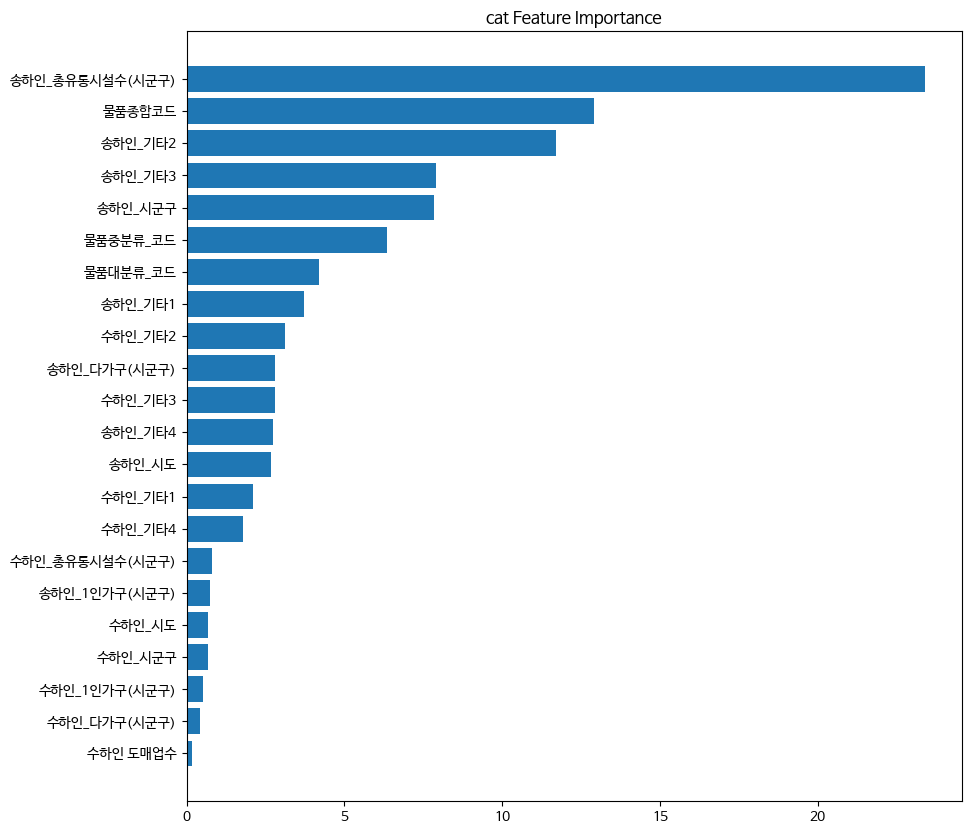

In [ ]:
feature_importance = cat.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10,10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('cat Feature Importance')

In [ ]:
submission_df

,index,운송장_건수,운송장건수
0,0,9.560699,NaN
1,1,4.809032,NaN
2,2,5.511663,NaN
3,3,3.794858,NaN
4,4,3.000000,3.0
...,...,...,...
7915,7915,4.175962,NaN
7916,7916,4.953761,NaN
7917,7917,3.481328,NaN
7918,7918,4.248571,NaN


# 하이퍼 파라미터 튜닝

In [ ]:
## 랜덤 포레스트 그리드 서치
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor()

rf_param_grid={
    'max_depth' : [5,7,10],
    'min_samples_leaf' : [8, 12, 18],
    'min_samples_split' : [8, 16, 20]
}

#score종류는 acc,f1,f1_micro,f1_macro등 원하는걸로 설정)
#여기서 설정 파라미터의 갯수(총 4000개의 조합이므로 4000번의 학습이 돌아감)
rf_grid = GridSearchCV(rf, param_grid=rf_param_grid, scoring="neg_root_mean_squared_error", n_jobs=-1, verbose=0)

# 그리드 서치 수행 (학습 데이터에 대해)
rf_grid.fit(X_train, y_train)

# 최적의 f1_macro 수치와 해당 파라미터 출력
print("최적의 log_loss : {0: .4f}".format(-rf_grid.best_score_))
print("최적의 파라미터 : ", rf_grid.best_params_)

최적의 log_loss :  6.1781
최적의 파라미터 :  {'max_depth': 10, 'min_samples_leaf': 18, 'min_samples_split': 16}


In [ ]:
## gbm 그리드 서치
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
gbr = GradientBoostingRegressor()

gbr_param_grid={
    'learning_rate' : [0.01,0.05],
    'max_depth' : [5,7,10],
    'min_samples_leaf' : [8, 12, 18],
    'min_samples_split' : [8, 16, 20]
}

#score종류는 acc,f1,f1_micro,f1_macro등 원하는걸로 설정)
#여기서 설정 파라미터의 갯수(총 4000개의 조합이므로 4000번의 학습이 돌아감)
gbr_grid = GridSearchCV(gbr, param_grid=rf_param_grid, scoring="neg_root_mean_squared_error", n_jobs=-1, verbose=0)

# 그리드 서치 수행 (학습 데이터에 대해)
gbr_grid.fit(X_train, y_train)

# 최적의 f1_macro 수치와 해당 파라미터 출력
print("최적의 log_loss : {0: .4f}".format(-gbr_grid.best_score_))
print("최적의 파라미터 : ", gbr_grid.best_params_)

최적의 log_loss :  6.2174
최적의 파라미터 :  {'max_depth': 5, 'min_samples_leaf': 18, 'min_samples_split': 16}


## optuna

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.1 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from optuna import create_study
sampler = optuna.samplers.TPESampler()

###Catboost

In [ ]:
cat_features = ['송하인_시도', '송하인_시군구', '송하인_기타1', '송하인_기타2', '송하인_기타3', '송하인_기타4',
       '수하인_시도', '수하인_시군구', '수하인_기타1', '수하인_기타2', '수하인_기타3', '수하인_기타4',
       '물품대분류_코드','물품중분류_코드', '물품종합코드']

In [ ]:
def objective(trial: Trial) -> float:
    params_cb = {
        "random_state": 42,
        "verbose": False,
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.15),
        "n_estimators": trial.suggest_int("n_estimators", 1000, 5000),
        "max_depth": trial.suggest_int("max_depth", 1, 16),
        "random_strength": trial.suggest_int("random_strength", 0, 100),
        "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    X_train, X_valid, y_train, y_valid = train_test_split(X, target, test_size=0.2)

    model = CatBoostRegressor(**params_cb)
    model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_valid,y_valid)],
          early_stopping_rounds=100, cat_features=cat_features)
    y_pred = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2024-03-31 15:05:20,063] A new study created in memory with name: no-name-8a9f930c-5f2b-4826-bc42-1ecab3aa3385
[I 2024-03-31 15:07:18,053] Trial 0 finished with value: 5.518150489474079 and parameters: {'learning_rate': 0.13138163646915668, 'n_estimators': 2730, 'max_depth': 7, 'random_strength': 88, 'colsample_bylevel': 0.4287253841823525, 'min_child_samples': 36}. Best is trial 0 with value: 5.518150489474079.
[I 2024-03-31 15:35:35,797] Trial 1 finished with value: 5.67243844376392 and parameters: {'learning_rate': 0.1405978801642095, 'n_estimators': 1375, 'max_depth': 16, 'random_strength': 23, 'colsample_bylevel': 0.5113047163877072, 'min_child_samples': 31}. Best is trial 0 with value: 5.518150489474079.
[I 2024-03-31 15:36:36,373] Trial 2 finished with value: 5.977050121011058 and parameters: {'learning_rate': 0.06479205733337552, 'n_estimators': 1934, 'max_depth': 8, 'random_strength': 4, 'colsample_bylevel': 0.45740411541347137, 'min_child_samples': 37}. Best is trial 0 wit

Best Score: 5.492264667817354
Best trial: {'learning_rate': 0.08221665061687011, 'n_estimators': 2182, 'max_depth': 14, 'random_strength': 69, 'colsample_bylevel': 0.7912240723984773, 'min_child_samples': 36}


In [ ]:
cat_models={}
cat_preds=[]
scores=[]
cat_features = ['송하인_시도', '송하인_시군구', '송하인_기타1', '송하인_기타2', '송하인_기타3', '송하인_기타4',
       '수하인_시도', '수하인_시군구', '수하인_기타1', '수하인_기타2', '수하인_기타3', '수하인_기타4',
       '물품대분류_코드','물품중분류_코드', '물품종합코드']

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in skf.split(X, target):
  folds.append((train_idx,valid_idx))

for fold in range(10):
  print(f'===================================={fold+1}============================================')
  train_idx, valid_idx = folds[fold]
  X_train = X.iloc[train_idx]
  X_valid = X.iloc[valid_idx]
  y_train = target[train_idx].values
  y_valid = target[valid_idx].values

  cat = CatBoostRegressor(learning_rate= 0.13138163646915668,
                          n_estimators= 2730, max_depth= 7,
                          random_strength=88, colsample_bylevel= 0.4287253841823525,
                          min_child_samples=36)
  cat.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_valid,y_valid)],
          early_stopping_rounds=100,cat_features=cat_features,
          verbose=100)
  cat_models[fold] = cat
  pred_valid = cat.predict(X_valid)
  cat_preds.append(cat.predict(X_test))

  rmse = np.sqrt(mean_squared_error(y_valid, pred_valid))
  scores.append(rmse)
  print(f'Fold {fold+1}의 RMSE 점수: {rmse}')
  print(f'================================================================================\n\n')

mean_score = np.mean(scores)
print(f'최종 교차 검증 RMSE 평균 점수: {mean_score}')

cat_result=sum(cat_preds)/10

### XGB

In [ ]:
def objective(trial: Trial) -> float:
    params_xgb = {
        "random_state": 42,
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.15),
        "n_estimators": trial.suggest_int("n_estimators", 1000, 5000),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "max_bin": trial.suggest_int("max_bin", 200, 500),  # 수정: 허용된 범위 내의 값으로 수정
    }

    X_train, X_valid, y_train, y_valid = train_test_split(X, target, test_size=0.2)

    model = XGBRegressor(**params_xgb,verbosity=0)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

    y_pred = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2024-03-31 17:19:12,667] A new study created in memory with name: no-name-27db1e97-8a18-4601-b5fa-c6203e11ed91
[I 2024-03-31 17:19:27,138] Trial 0 finished with value: 6.5053602254455125 and parameters: {'learning_rate': 0.08080884143533593, 'n_estimators': 1735, 'max_depth': 5, 'num_leaves': 85, 'colsample_bytree': 0.6396530840417981, 'max_bin': 498}. Best is trial 0 with value: 6.5053602254455125.
[I 2024-03-31 17:19:51,836] Trial 1 finished with value: 6.765166322804134 and parameters: {'learning_rate': 0.14131107703388454, 'n_estimators': 3948, 'max_depth': 3, 'num_leaves': 139, 'colsample_bytree': 0.7048251106640897, 'max_bin': 381}. Best is trial 0 with value: 6.5053602254455125.
[I 2024-03-31 17:20:06,933] Trial 2 finished with value: 6.895643334503533 and parameters: {'learning_rate': 0.10050373381277698, 'n_estimators': 2108, 'max_depth': 5, 'num_leaves': 204, 'colsample_bytree': 0.46807047886366365, 'max_bin': 234}. Best is trial 0 with value: 6.5053602254455125.
[I 2024-0

Best Score: 5.382153151191348
Best trial: {'learning_rate': 0.07295613260343212, 'n_estimators': 2508, 'max_depth': 3, 'num_leaves': 204, 'colsample_bytree': 0.9289713437810366, 'max_bin': 363}


In [ ]:
xgb_models={}
xgb_preds=[]
scores=[]

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in skf.split(X, target):
  folds.append((train_idx,valid_idx))

for fold in range(10):
  print(f'===================================={fold+1}============================================')
  train_idx, valid_idx = folds[fold]
  X_train = X.iloc[train_idx]
  X_valid = X.iloc[valid_idx]
  y_train = target[train_idx].values
  y_valid = target[valid_idx].values

  xgb = XGBRegressor(learning_rate= 0.07295613260343212,
                     n_estimators=2508, max_depth= 3, num_leaves=204,
                     colsample_bytree= 0.9289713437810366, max_bin= 363)
  xgb.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_valid,y_valid)],
          early_stopping_rounds=100,
          verbose=100)
  xgb_models[fold] = xgb
  pred_valid = xgb.predict(X_valid)
  xgb_preds.append(xgb.predict(X_test))

  rmse = np.sqrt(mean_squared_error(y_valid, pred_valid))
  scores.append(rmse)
  print(f'Fold {fold+1}의 RMSE 점수: {rmse}')
  print(f'================================================================================\n\n')

mean_score = np.mean(scores)
print(f'최종 교차 검증 RMSE 평균 점수: {mean_score}')

# 결과값 합친 후 나눠주기
xgb_result = sum(xgb_preds)/10

====================================1============================================
[0]	validation_0-rmse:6.68765	validation_1-rmse:6.58122
[100]	validation_0-rmse:5.97544	validation_1-rmse:5.85453
[200]	validation_0-rmse:5.80873	validation_1-rmse:5.83728
[300]	validation_0-rmse:5.69539	validation_1-rmse:5.80202
[400]	validation_0-rmse:5.59275	validation_1-rmse:5.77819
[500]	validation_0-rmse:5.50525	validation_1-rmse:5.75122
[600]	validation_0-rmse:5.44367	validation_1-rmse:5.74081
[700]	validation_0-rmse:5.39798	validation_1-rmse:5.73546
[768]	validation_0-rmse:5.35672	validation_1-rmse:5.73994
Fold 1의 RMSE 점수: 5.733326926246801


====================================2============================================
[0]	validation_0-rmse:6.19141	validation_1-rmse:10.12646
[100]	validation_0-rmse:5.57022	validation_1-rmse:9.10716
[200]	validation_0-rmse:5.45930	validation_1-rmse:9.05738
[300]	validation_0-rmse:5.34253	validation_1-rmse:8.98277
[400]	validation_0-rmse:5.24348	validation_1-rms

## pycaret

In [ ]:
!python -m pip install --upgrade pip setuptools

In [ ]:
!python -m pip install pycaret[full]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.9/485.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 1.8 MB/

In [ ]:
from pycaret.regression import *

ModuleNotFoundError: No module named 'pycaret'

In [ ]:
s_train = train.sample(frac=0.9, random_state=42)
s_test = train.drop(s_train.index)

In [ ]:
pycaretmodel = setup(session_id=42, data = s_train, target='운송장_건수', test_data = s_test,
                     normalize=False, fold_strategy='stratifiedkfold', use_gpu=True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

,Description,Value
0,Session id,42
1,Target,운송장_건수
2,Target type,Regression
3,Original data shape,"(31684, 35)"
4,Transformed data shape,"(31684, 35)"
5,Transformed train set shape,"(28516, 35)"
6,Transformed test set shape,"(3168, 35)"
7,Numeric features,34
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

In [ ]:
best_model = compare_models(sort="RMSE")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2.2964,38.1074,6.0918,0.1100,0.4212,0.4357,6.6400
lightgbm,Light Gradient Boosting Machine,2.3180,38.4822,6.1293,0.0973,0.4284,0.4408,0.5470
rf,Random Forest Regressor,2.5600,41.3172,6.3502,0.0321,0.4619,0.5164,27.0660
xgboost,Extreme Gradient Boosting,2.4195,42.4133,6.3985,0.0279,0.4521,0.4605,0.9380
et,Extra Trees Regressor,2.5659,43.4344,6.4815,-0.0011,0.4674,0.5121,14.4750
lr,Linear Regression,2.3959,44.0728,6.5107,0.0118,0.4383,0.4575,0.2810
ridge,Ridge Regression,2.3955,44.0765,6.5109,0.0118,0.4381,0.4574,0.1400
lasso,Lasso Regression,2.3995,44.2776,6.5254,0.0075,0.4375,0.4590,0.2230
llar,Lasso Least Angle Regression,2.3995,44.2776,6.5254,0.0075,0.4375,0.4590,0.1360
en,Elastic Net,2.4000,44.2772,6.5255,0.0074,0.4377,0.4591,0.1500


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [ ]:
gbr = create_model('gbr')
lgbm = create_model('lightgbm')

blender2 = blend_models(estimator_list=[gbr,lgbm])


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.2627,31.4021,5.6038,0.0219,0.4228,0.4339
1,2.2644,34.2360,5.8512,0.3941,0.4151,0.4357
2,2.2886,31.1151,5.5781,-0.1946,0.4221,0.4409
3,2.2390,28.4993,5.3385,0.2915,0.4151,0.4305
4,2.2956,38.0399,6.1677,0.0317,0.4251,0.4358
5,2.2795,32.6762,5.7163,0.2182,0.4231,0.4339
6,2.3035,33.7371,5.8084,0.0875,0.4217,0.4382
7,2.2795,34.9965,5.9158,0.0477,0.4174,0.4235
8,2.4531,81.2977,9.0165,0.1949,0.4276,0.4473


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.3210,33.6241,5.7986,-0.0473,0.4364,0.4511
1,2.2841,36.2031,6.0169,0.3592,0.4205,0.4356
2,2.2763,30.5282,5.5252,-0.1721,0.4219,0.4337
3,2.2288,27.6539,5.2587,0.3125,0.4179,0.4297
4,2.3707,41.0297,6.4054,-0.0444,0.4423,0.4602
5,2.3127,33.4524,5.7838,0.1996,0.4316,0.4370
6,2.2720,33.4214,5.7811,0.0960,0.4223,0.4329
7,2.3415,34.8090,5.8999,0.0528,0.4312,0.4367
8,2.4442,78.6142,8.8665,0.2214,0.4283,0.4466


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.2723,31.8737,5.6457,0.0072,0.4260,0.4388
1,2.2512,34.8081,5.8998,0.3839,0.4142,0.4313
2,2.2593,30.4394,5.5172,-0.1687,0.4165,0.4318
3,2.2158,27.6655,5.2598,0.3122,0.4125,0.4268
4,2.3126,38.6081,6.2135,0.0172,0.4289,0.4435
5,2.2772,32.6779,5.7165,0.2181,0.4216,0.4313
6,2.2661,32.8060,5.7277,0.1127,0.4174,0.4320
7,2.2945,34.5236,5.8757,0.0606,0.4187,0.4265
8,2.4310,79.4827,8.9153,0.2128,0.4247,0.4428


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
tuned_blender = tune_model(blender2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.2653,31.6446,5.6254,0.0143,0.4239,0.4369
1,2.2502,34.5964,5.8819,0.3877,0.4132,0.4315
2,2.2615,30.5314,5.5255,-0.1722,0.4169,0.4330
3,2.2184,27.7901,5.2716,0.3091,0.4120,0.4271
4,2.3038,38.3036,6.1890,0.0250,0.4270,0.4407
5,2.2754,32.6072,5.7103,0.2198,0.4209,0.4314
6,2.2713,32.8880,5.7348,0.1104,0.4177,0.4330
7,2.2879,34.5677,5.8794,0.0594,0.4174,0.4252
8,2.4338,79.8306,8.9348,0.2094,0.4241,0.4433


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
tuned_rf = tune_model(gbr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.2712,30.8577,5.5550,0.0389,0.4193,0.4398
1,2.2991,43.2211,6.5743,0.2350,0.4124,0.4372
2,2.2685,26.8202,5.1788,-0.0297,0.4172,0.4405
3,2.2546,30.3114,5.5056,0.2464,0.4120,0.4359
4,2.3129,38.2009,6.1807,0.0276,0.4240,0.4443
5,2.2847,32.6270,5.7120,0.2193,0.4156,0.4351
6,2.2644,31.8473,5.6433,0.1386,0.4153,0.4371
7,2.3051,34.9365,5.9107,0.0494,0.4180,0.4344
8,2.4232,85.4843,9.2458,0.1534,0.4193,0.4418


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
final_model = finalize_model(blender2)

In [ ]:
prediction = predict_model(final_model, data = X_test)

# 앙상블 Ensemble
* catboost, rf, xgboost, lr \
* catboost, gbm, xgboost, lr, rf \
두 가지로 시행해볼 계획

##보팅
rf, gbm, xgb, cat

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
best_models = [
    ('rf', RandomForestRegressor(max_depth=10, min_samples_leaf= 18,
                                  min_samples_split= 16)),
    ('XGB', XGBRegressor(learning_rate= 0.07295613260343212,
                         n_estimators=2508, max_depth= 3, num_leaves=204,
                         colsample_bytree= 0.9289713437810366, max_bin= 363)),
    ('cat', CatBoostRegressor(learning_rate= 0.13138163646915668,
                              n_estimators= 2730, max_depth= 7,
                              random_strength=88, colsample_bylevel= 0.4287253841823525,
                              min_child_samples=36)),
    ('lr', LinearRegression())
]

#앙상블 기법을 위한 패키지
from sklearn.ensemble import VotingRegressor

#앙상블 모델 학습
voting_rg = VotingRegressor(estimators=best_models,verbose=0)
voting_rg.fit(X_train,y_train)

vote_pred = voting_rg.predict(X_test)

submission_df.iloc[:,1] = vote_pred
submission_df.to_csv("voting_ensemble.csv",index = False)


In [ ]:
#GBM 까지 추가

best_models = [
    ('rf', RandomForestRegressor(max_depth=10, min_samples_leaf= 18,
                                  min_samples_split= 16)),
    ('GBR', GradientBoostingRegressor(max_depth= 5,
                                      min_samples_leaf= 18,
                                      min_samples_split= 16, learning_rate=0.01)),
    ('XGB', XGBRegressor(learning_rate= 0.07295613260343212,
                        n_estimators=2508, max_depth= 3, num_leaves=204,
                        colsample_bytree= 0.9289713437810366, max_bin= 363)),
    ('cat', CatBoostRegressor(learning_rate= 0.13138163646915668,
                              n_estimators= 2730, max_depth= 7,
                              random_strength=88, colsample_bylevel= 0.4287253841823525,
                              min_child_samples=36)),
    ('lr', LinearRegression())
]

#앙상블 기법을 위한 패키지를
from sklearn.ensemble import VotingRegressor

#앙상블 모델을 학습
voting_rg = VotingRegressor(estimators=best_models,verbose=0)
voting_rg.fit(X_train,y_train)

vote_pred = voting_rg.predict(X_test)

submission_df.iloc[:,1] = vote_pred
submission_df.to_csv("voting_gbm_ensemble.csv",index = False)

In [ ]:
best_models = [
    ('rf', RandomForestRegressor(max_depth=10, min_samples_leaf= 18,
                                  min_samples_split= 16)),
    ('GBR', GradientBoostingRegressor(max_depth= 5,
                                      min_samples_leaf= 18,
                                      min_samples_split= 16, learning_rate=0.01)),
    ('XGB', XGBRegressor(learning_rate= 0.07295613260343212,
                        n_estimators=2508, max_depth= 3, num_leaves=204,
                        colsample_bytree= 0.9289713437810366, max_bin= 363)),
    ('lr', LinearRegression())
]

#앙상블 기법을 위한 패키지를
from sklearn.ensemble import VotingRegressor

#앙상블 모델을 학습
voting_rg = VotingRegressor(estimators=best_models,verbose=0)
voting_rg.fit(X_train,y_train)

vote_pred = voting_rg.predict(X_test)

submission_df.iloc[:,1] = vote_pred
submission_df.to_csv("voting_gbm_ensemble.csv",index = False)

## 스태킹

In [ ]:
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=1ef908304fb91aef6f8875bb1a5d32910535b2e3303cd40700eb47c841785d43
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [ ]:
import utils

In [ ]:
from sklearn.ensemble import StackingRegressor
stack_models = [
    ('rf', RandomForestRegressor(max_depth=10, min_samples_leaf= 18,
                                  min_samples_split= 16)),
    ('GBR', GradientBoostingRegressor(max_depth= 5,
                                      min_samples_leaf= 18,
                                      min_samples_split= 16, learning_rate=0.01)),
    ('XGB', XGBRegressor(learning_rate= 0.07295613260343212,
                        n_estimators=2508, max_depth= 3, num_leaves=204,
                        colsample_bytree= 0.9289713437810366, max_bin= 363)),
    ('cat', CatBoostRegressor(learning_rate= 0.13138163646915668,
                              n_estimators= 2730, max_depth= 7,
                              random_strength=88, colsample_bylevel= 0.4287253841823525,
                              min_child_samples=36)),
    ('lr', LinearRegression())
]
stack_reg = StackingRegressor(stack_models, final_estimator=xgb, n_jobs=-1)
stack_reg.fit(X_train, y_train)
stack_pred = stack_reg.predict(X_test)

In [ ]:
submission_df.iloc[:,1] = stack_pred
submission_df.to_csv("stacking_rf_gbm_cat_xgb_lr.csv",index=False)

#모델링 마무리(결과 입력)

In [ ]:
submission_df.head(10)

,index,운송장_건수
0,0,6.506856
1,1,3.570226
2,2,4.492011
3,3,4.042966
4,4,5.149887
5,5,4.975370
6,6,5.026032
7,7,3.888645
8,8,3.325386
9,9,4.570955


In [ ]:
submission_df.iloc[:, 1] = pred

(array([7.855e+03, 6.100e+01, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ -0.98554074,  11.32555735,  23.63665544,  35.94775353,
         48.25885163,  60.56994972,  72.88104781,  85.1921459 ,
         97.503244  , 109.81434209, 122.12544018]),
 <BarContainer object of 10 artists>)

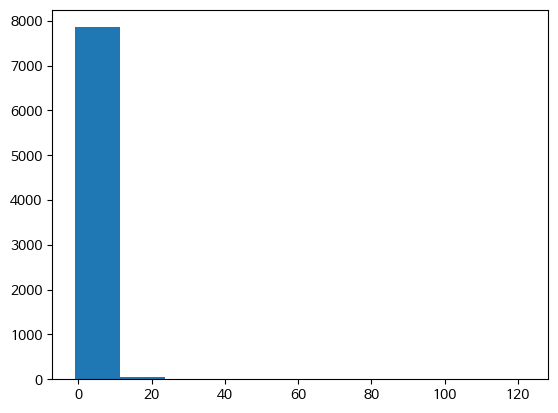

In [ ]:
plt.hist(submission_df['운송장_건수'])

##음수인거 처리까지 완료하기

#pycaret + grid_Search?

In [ ]:
submission_df[submission_df['운송장_건수']<1]

,index,운송장_건수
1232,1232,-0.883300
1250,1250,0.946086
1322,1322,0.313677
1565,1565,0.961932
1581,1581,-0.985541
1583,1583,0.210208
1585,1585,0.149738
1686,1686,0.726419


In [ ]:
#3보다 작은 값 확인<
submission_df.loc[submission_df['운송장_건수']<2, '운송장_건수'] = 2

In [ ]:
submission_df.to_csv('cat.csv', index=False)